# Problem Set #3

Dr. Evans MACS 30100

Xiuyuan Zhang

## Question 1

### (a) Plot a histogram of percentages of the income.txt data with 30 bins. Make sure that the bins are weighted using the normed=True option. Make sure your plot has correct x-axis and y-axis labels as well as a plot title.

In [114]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.optimize as opt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.integrate as intgr


income_data = np.loadtxt("incomes.txt")

<IPython.core.display.Javascript object>


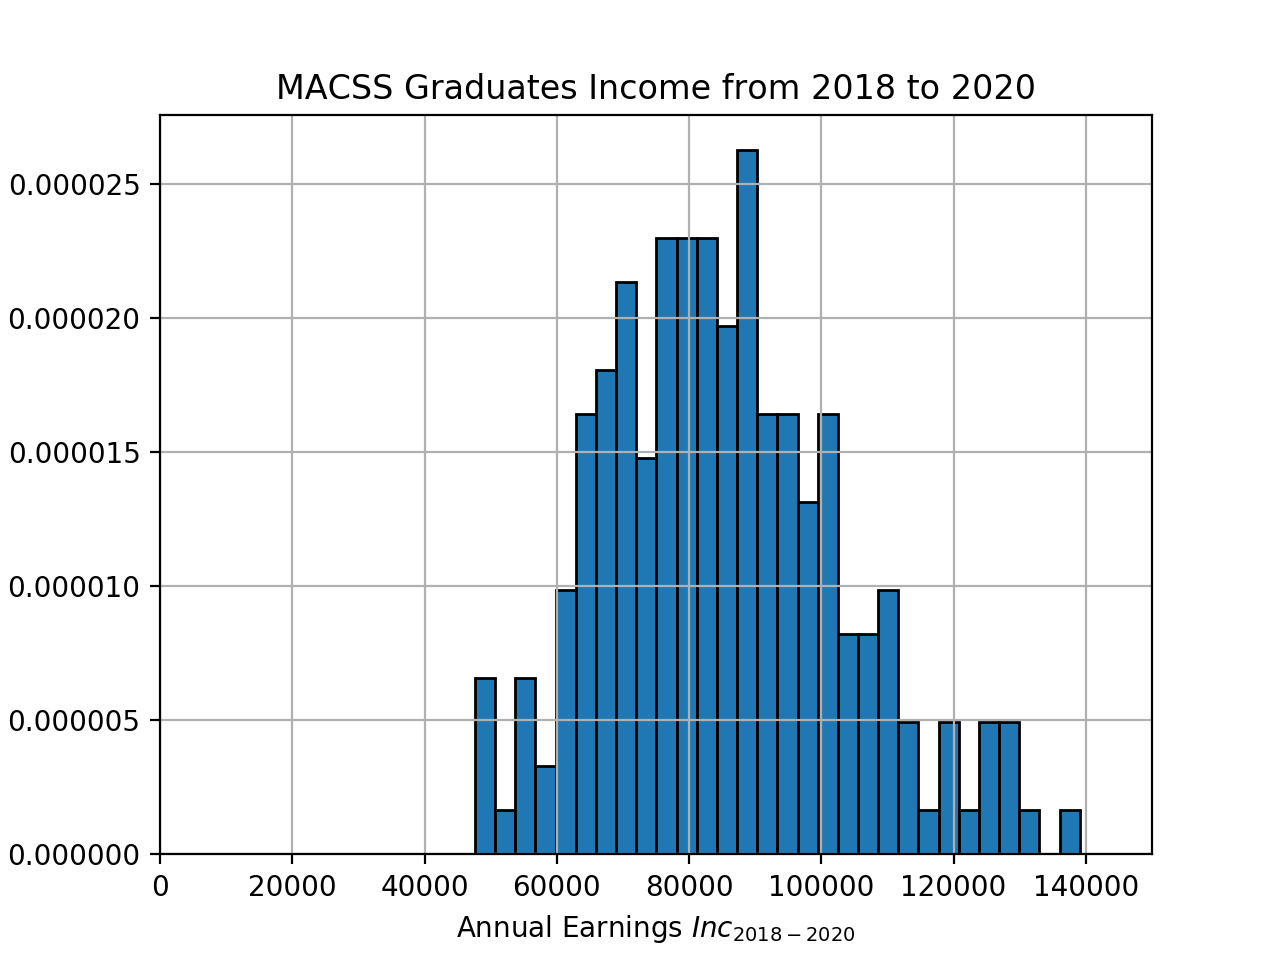

In [115]:
%matplotlib notebook

# plot the histogram for (a)
plt.hist(income_data, bins = 30, edgecolor ='black', normed = True)
plt.xlim(0.01, 150000)

plt.title('MACSS Graduates Income from 2018 to 2020')
plt.ylabel('Percentage')
plt.xlabel('Annual Earnings $Inc_{2018-2020}$')
plt.grid(True)

plt.show()

### (b) Plot your estimated lognormal PDF against the histogram from part (a). Report the value of your GMM criterion function at the estimated parameter values. Report and compare your two data moments against your two model moments at the estimated parameter values.

In [4]:
mu_income = np.mean(income_data)
sig_income = np.std(income_data)

In [118]:
def calculate_pdf(xvals, mu, sigma):
    '''
    Calculate log normal distribution.
    
    Inputs: xvals(numpy array)
            mu (float): mean
            sigma (float): standard deviation

    Returns: pdf_vals(numpy array)
    '''
    pdf_vals = (1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)))
    
                
    return pdf_vals

In [120]:
def compute_model_moments(mu, sigma):
    '''
    Computes the two model moments for GMM (mean(model data), variance(model data))
    
    Inputs: mu (float): mean
            sigma (float): standard deviation
            
    Returns: mean_model, sig_model
    '''   
    mean_model = np.exp(mu + sigma ** 2/2)
    var_model = (np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma**2)
    sig_model = np.sqrt(var_model)
    
    return mean_model, sig_model

def compute_err_vec(xvals, mu, sigma, simple):
    '''
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    
    Inputs:
            xvals(datatable): test scores data
            mu(float): mean
            sigma(float): standard deviation
            simple(boolean): =True if errors are simple difference, 
                             =False if errors are percent deviation from data moments  
    Returns: err_vec
    
    '''
    mean_data = np.mean(xvals)
    sig_data = np.std(xvals)
    moms_data = np.array([[mean_data], [sig_data]])
    mean_model, sig_model = compute_model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [sig_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def set_criterion(params, *args):
    '''
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    
    Inputs: params(list): mu, sigma
            args(tuple): xvals: data 
                         W_hat: (R, R) matrix, estimate of optimal weighting matrix
    Returns: crit_val
    ''' 
    mu, sigma = params
    xvals, W = args
    err = compute_err_vec(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val


In [121]:
# Using an initial estimate mu and sigma to get the GMM estimates
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (income_data, W_hat)
results = opt.minimize(set_criterion, params_init, args=(gmm_args),\
                       method='L-BFGS-B', bounds=((0.1, None), (0.1, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mu_GMM1= 11.3318810063  sig_GMM1= 0.208696571254


<IPython.core.display.Javascript object>


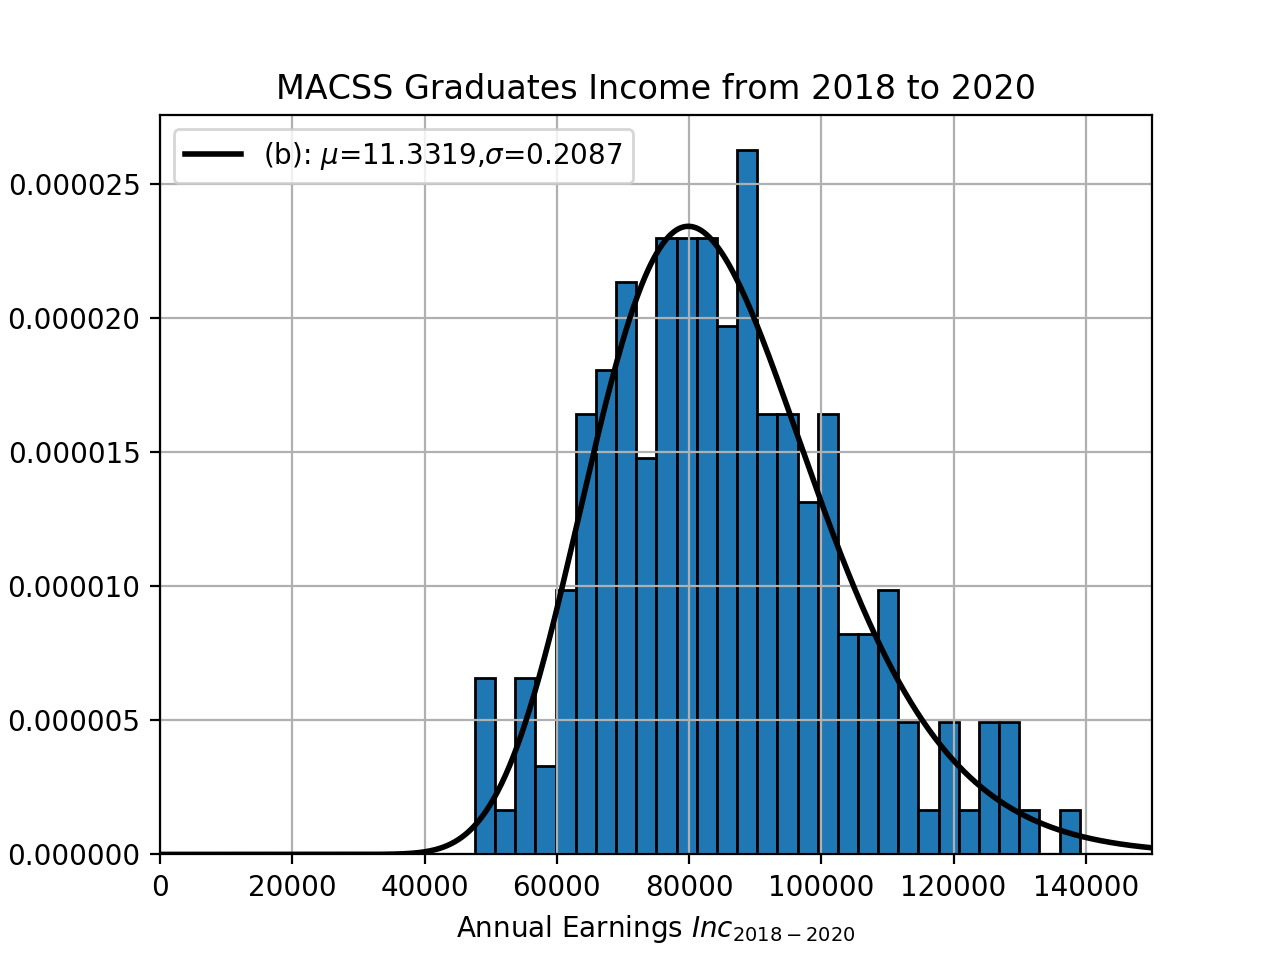

In [122]:
# Plot the distribution using new generated estimates against the histogram from (a)
dist_income = np.linspace(0.01, 150000, 1000)

%matplotlib notebook

# plot the histogram for (a)
plt.hist(income_data, bins = 30, edgecolor ='black', normed = True)
plt.xlim(0.01, 150000)

plt.title('MACSS Graduates Income from 2018 to 2020')
plt.ylabel('Percentage')
plt.xlabel('Annual Earnings $Inc_{2018-2020}$')
plt.grid(True)

plt.plot(dist_income, calculate_pdf(dist_income, mu_GMM1, sig_GMM1),
         linewidth=2, color='k', label='(b): $\mu$=11.3319,$\sigma$=0.2087')
plt.legend(loc='upper left')

plt.show()

In [123]:
mean_model, sig_model = compute_model_moments(mu_GMM1, sig_GMM1)
err_income1 = compute_err_vec(income_data, mu_GMM1, sig_GMM1, False).reshape(2,)

print("The value from the GMM criterion function is", results.fun)
print("")
print("The two data moments are")
print("(1) the mean of data =", mu_income, "and the standard deviation of data =", sig_income)
print("")
print("The two model moments are")
print("mean of model =", mean_model, "and the standard deviation of model =", sig_model)
print("")
print("The mean and standard deviation of the model are close to the mean and standard deviation of the data as shown above.")
print("Error vector=", err_income1)


The value from the GMM criterion function is [[  1.09918800e-13]]

The two data moments are
(1) the mean of data = 85276.8236063 and the standard deviation of data = 17992.542128

The two model moments are
mean of model = 85276.8358589 and the standard deviation of model = 17992.5367521

The mean and standard deviation of the model are close to the mean and standard deviation of the data as shown above.
Error vector= [  1.43680413e-07  -2.98788786e-07]


### (c) Report your estimates as well as the criterion function value at these estimates. Plot your estimated lognormal PDF against the histogram from part (a) and the estimated PDF from part (b). Report and compare your two data moments against your two model moments at the estimated parameter values.

In [124]:
err_income1_noshape = compute_err_vec(income_data, mu_GMM1, sig_GMM1, False)
VCV_2step = np.dot(err_income1_noshape, err_income1_noshape.T) / income_data.shape[0]
W_hat2 = lin.pinv(VCV_2step)
print("The variance covariance matrix is")
print(VCV_2step)
print("")
print("The optimal weighting matrix is" )
print(W_hat2)

The variance covariance matrix is
[[  1.03220305e-16  -2.14650481e-16]
 [ -2.14650481e-16   4.46373695e-16]]

The optimal weighting matrix is
[[  3.41728478e+14  -7.10637139e+14]
 [ -7.10637139e+14   1.47779648e+15]]


In [125]:
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (income_data, W_hat2)
results_2step = opt.minimize(set_criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (0.1, None)))
mu_GMM2, sig_GMM2 = results_2step.x
print("mu_GMM2 is", mu_GMM2, "and sig_GMM2 is", sig_GMM2)

mu_GMM2 is 11.3318810952 and sig_GMM2 is 0.208696635022


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


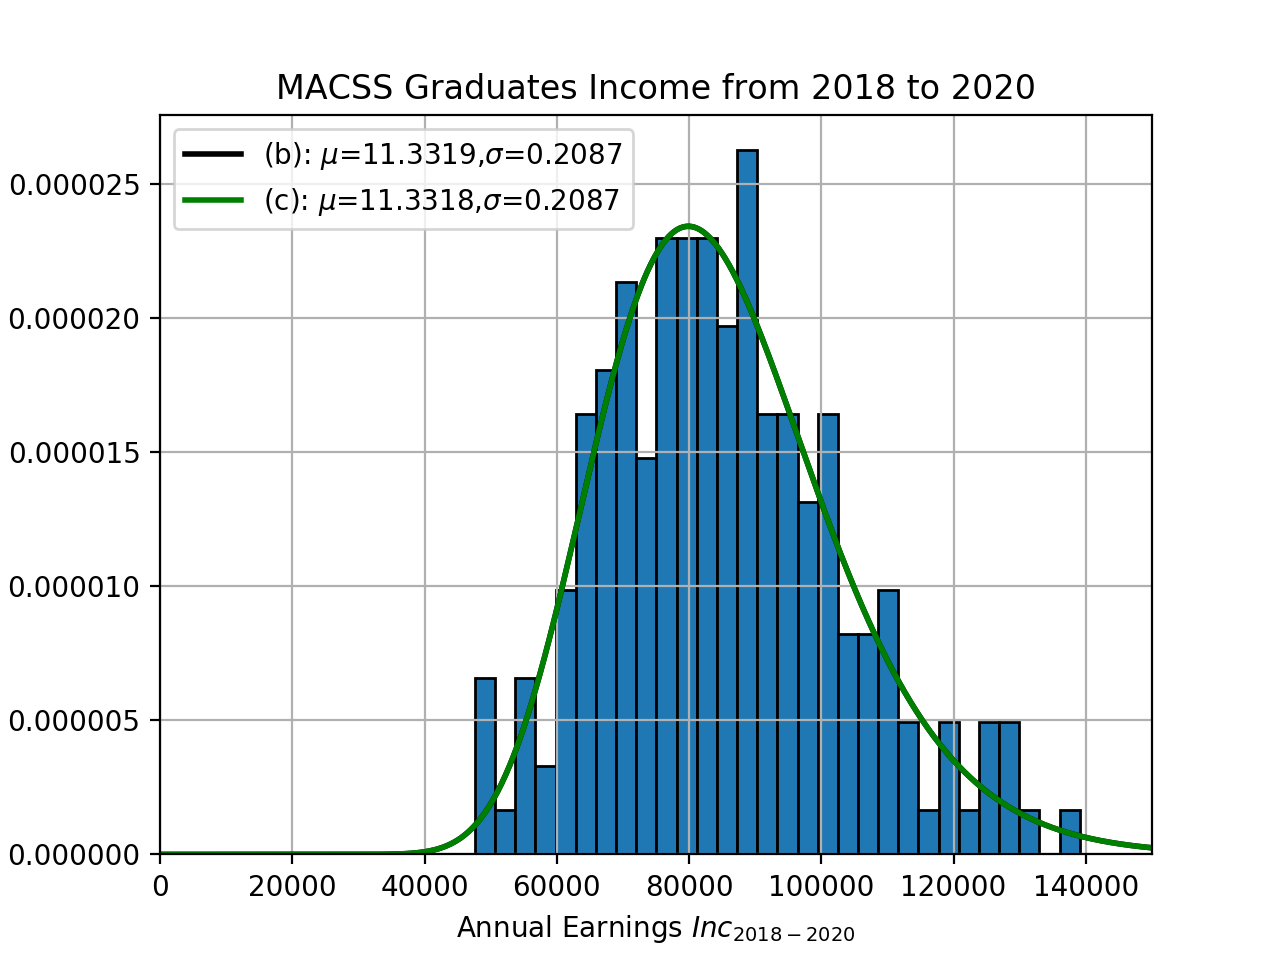

In [126]:
# Plot the 2 steps GMM distribution
%matplotlib notebook

# plot the histogram for (a)
plt.hist(income_data, bins = 30, edgecolor ='black', normed = True)
plt.xlim(0.01, 150000)

plt.title('MACSS Graduates Income from 2018 to 2020')
plt.ylabel('Percentage')
plt.xlabel('Annual Earnings $Inc_{2018-2020}$')
plt.grid(True)

# plot the distribution for (b)
plt.plot(dist_income, calculate_pdf(dist_income, mu_GMM1, sig_GMM1),
         linewidth=2, color='k', label='(b): $\mu$=11.3319,$\sigma$=0.2087')
plt.legend(loc='upper left')

# plot the distribution for (b)
plt.plot(dist_income, calculate_pdf(dist_income, mu_GMM2, sig_GMM2),
         linewidth=2, color='g', label='(c): $\mu$=11.3318,$\sigma$=0.2087')
plt.legend(loc='upper left')

plt.show()

In [127]:
mean_model2, std_model2 = compute_model_moments(mu_GMM2, sig_GMM2)
err_2step = compute_err_vec(income_data, mu_GMM2, sig_GMM2, False).reshape(2,)

print('The value of GMM criterion function is', results_2step.fun)
print("")
print('The two data moments are')
print('the mean of data =', mu_income, ' and the standard deviation of data =', sig_income)
print("")
print('The two model moments are')
print('the mean of model =', mean_model2, ' and the tandard deviation of model =', std_model2)
print()
print('Error vector=', err_2step)

The value of GMM criterion function is [[ 0.00997106]]

The two data moments are
the mean of data = 85276.8236063  and the standard deviation of data = 17992.542128

The two model moments are
the mean of model = 85276.8445697  and the tandard deviation of model = 17992.5442083

Error vector= [  2.45828667e-07   1.15615606e-07]


### (d) Plot your estimated lognormal PDF against the histogram from part (a). Report the value of your GMM criterion function at the estimated parameter values. Report and compare your three data moments against your three model moments at the estimated parameter values.

In [128]:
def compute_data_moments3(xvals):
    '''
    This function computes the three data moments for GMM
    (binpct_1, binpct_2, binpct_3).
    
    Inputs: xvals(datatable): test scores data

    Returns: bpct_1
             bpct_2
             bpct_3
    '''
    bpct_1 = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2 = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] / xvals.shape[0])
    bpct_3 = xvals[xvals >=100000].shape[0] / xvals.shape[0]

    return bpct_1, bpct_2, bpct_3

def compute_model_moments3(mu, sigma):
    '''
    This function computes the three model moments for GMM
    (binpct_1, binpct_2, binpct_3).
    Inputs:
            mu(float): mean
            sigma(float): standard deviation
    
    Returns: bpct_1_mod
             bpct_2_mod
             bpct_3_mod
    '''
    bpct_1_mod = sts.norm.cdf(np.log(75000), loc = mu, scale = sigma)
    bpct_2_mod = sts.norm.cdf(np.log(100000), loc = mu, scale = sigma) - bpct_1_mod
    bpct_3_mod = 1 - sts.norm.cdf(np.log(100000), loc = mu, scale = sigma)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def compute_err_vec3(xvals, mu, sigma, simple):
    '''
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.

    Inputs:
            xvals(datatable): test scores data
            mu(float): mean
            sigma(float): standard deviation
            simple(boolean): =True if errors are simple difference, 
                             =False if errors are percent deviation from data moments 
    
    Returns: err_vec
    '''
    bpct_1, bpct_2, bpct_3 = compute_data_moments3(xvals)
    moms_data = np.array([[bpct_1], [bpct_2], [bpct_3]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = compute_model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec

def set_criterion3(params, *args):
    '''
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    
    Inputs:
            params(list): mu, sigma
            args(tuple): xvals: data 
                         W_hat: (R, R) matrix, estimate of optimal weighting matrix
    Returns: crit_val
    '''
    mu, sigma = params
    xvals, W = args
    err = compute_err_vec3(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val


In [129]:
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(3)
args1_3 = (income_data, W_hat)
results1_3 = opt.minimize(set_criterion3, params_init, args=(args1_3),
                       method='L-BFGS-B', bounds=((0.1, None), (0.1, None)))
mu_GMM1_3, sig_GMM1_3 = results1_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)

mu_GMM1_3= 11.3356813277  sig_GMM1_3= 0.210598453435


<IPython.core.display.Javascript object>


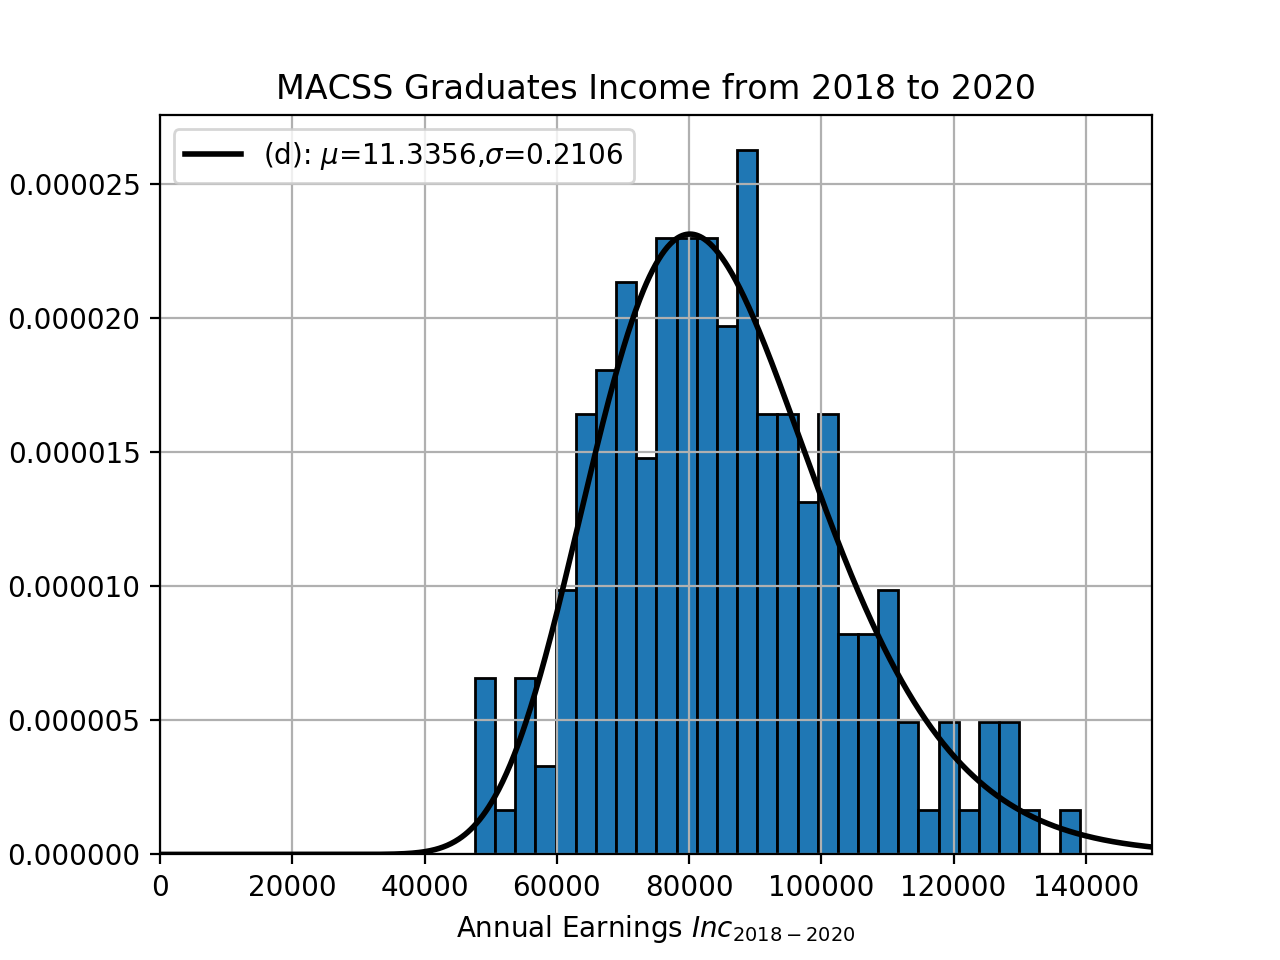

In [130]:
%matplotlib notebook

# plot the histogram for (a)
plt.hist(income_data, bins = 30, edgecolor ='black', normed = True)
plt.xlim(0.01, 150000)
plt.title('MACSS Graduates Income from 2018 to 2020')
plt.ylabel('Percentage')
plt.xlabel('Annual Earnings $Inc_{2018-2020}$')
plt.grid(True)

# plot the distribution for (d)
plt.plot(dist_income, calculate_pdf(dist_income, mu_GMM1_3, sig_GMM1_3),
         linewidth=2, color='k', label='(d): $\mu$=11.3356,$\sigma$=0.2106')
plt.legend(loc='upper left')

plt.show()

In [131]:
bpct_1, bpct_2, bpct_3 = compute_data_moments3(income_data)
bpct_1_mod, bpct_2_mod, bpct_3_mod = compute_model_moments3(mu_GMM_3, sig_GMM_3)
err1_3 = compute_err_vec(income_data, mu_GMM_3, sig_GMM_3, False).reshape(2,)

print('The value of GMM criterion function is', results_3.fun)
print("")
print('The three data moments are',bpct_1,", ",bpct_2,", and", bpct_3, ".")
print("")
print('The three model moments are',bpct_1_mod, ", ", bpct_2_mod, ", and", bpct_3_mod, ".")
print("")
print('The error vector is', err1_3, ".")

The value of GMM criterion function is [[ 67.20198777]]

The three data moments are 0.3 ,  0.5 , and 0.2 .

The three model moments are 0.300000002697 ,  0.500000002733 , and 0.199999994569 .

The error vector is [ 0.00420802  0.0135626 ] .


### (e) Report your estimates as well as the criterion function value at these estimates. Plot your estimated log- normal PDF against the histogram from part (a) and the estimated PDF from part (d). Report and compare your three data moments against your three model moments at the estimated parameter values.

In [132]:
err2_3= compute_err_vec3(income_data, mu_GMM1_3, sig_GMM1_3, False)
VCV2_3 = np.dot(err2_3, err2_3.T) / income_data.shape[0]
W_hat_3 = lin.pinv(VCV_3)

print('The variance covariance matrix is')
print(VCV2_3)
print("")
print('The optimal weighting matrix is')
print(W_hat_3)

The variance covariance matrix is
[[  4.64914309e-15   6.28386975e-15  -2.26833889e-14]
 [  6.28386975e-15   8.49339724e-15  -3.06592975e-14]
 [ -2.26833889e-14  -3.06592975e-14   1.10673327e-13]]

The optimal weighting matrix is
[[  3.03263615e+11   4.09896839e+11  -1.47963751e+12]
 [  4.09896839e+11   5.54024323e+11  -1.99990605e+12]
 [ -1.47963751e+12  -1.99990605e+12   7.21922136e+12]]


In [133]:
params_init3 = np.array([mu_GMM1_3, sig_GMM1_3])
args2_3 = (income_data, W_hat_3)
results2_3 = opt.minimize(set_criterion3, params_init3, args=(args2_3),
                       method='L-BFGS-B', bounds=((0.1, None), (0.1, None)))
mu_GMM2_3, sig_GMM2_3 = results2_3.x
print('mu_GMM2_3=', mu_GMM2_3, ' sig_GMM2_3=', sig_GMM2_3)

mu_GMM2_3= 11.3356813289  sig_GMM2_3= 0.21059845554


<IPython.core.display.Javascript object>


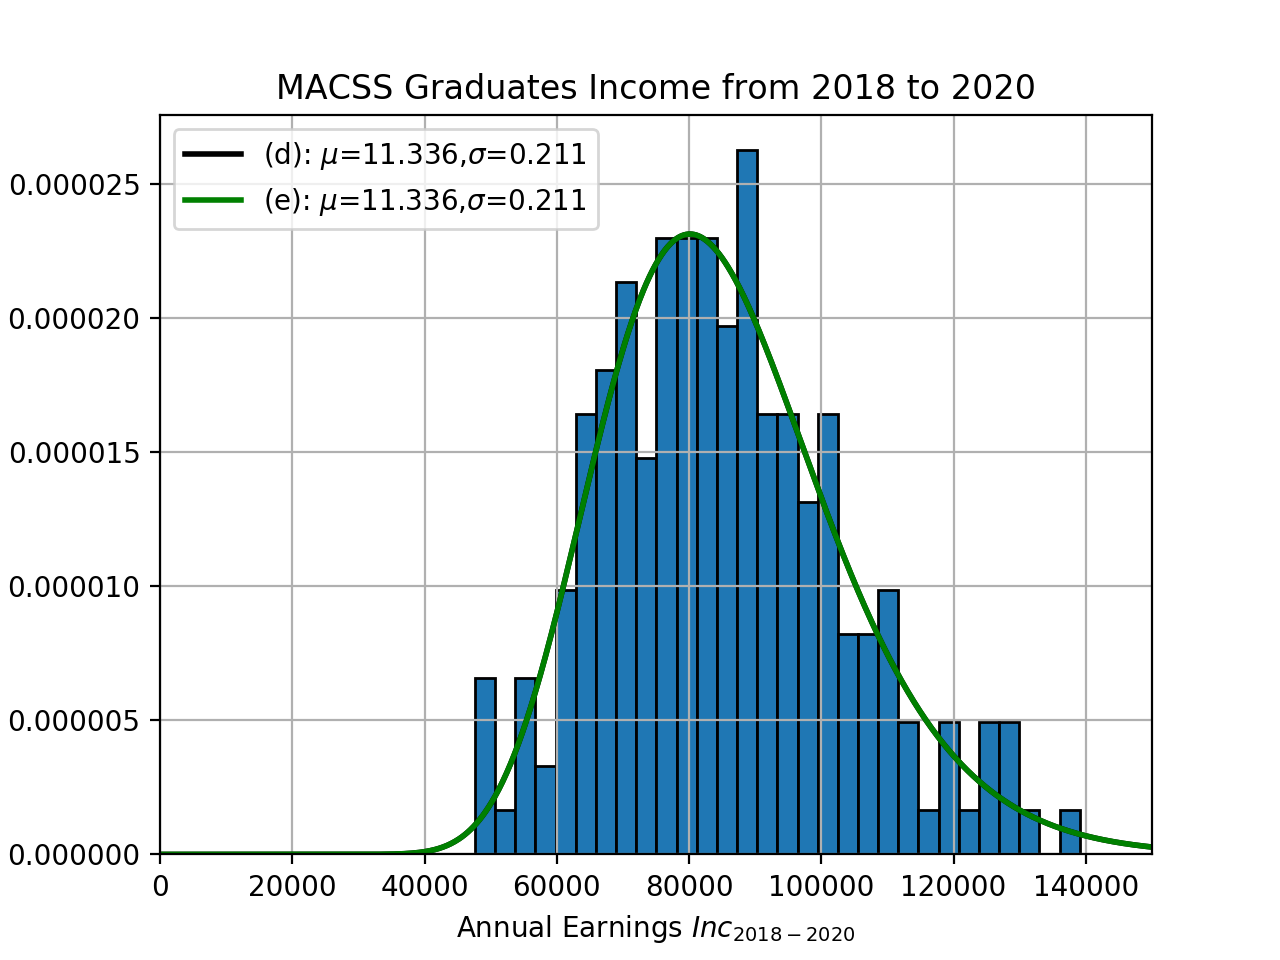

In [134]:
%matplotlib notebook

# plot the histogram for (a)
plt.hist(income_data, bins = 30, edgecolor ='black', normed = True)
plt.xlim(0.01, 150000)
plt.title('MACSS Graduates Income from 2018 to 2020')
plt.ylabel('Percentage')
plt.xlabel('Annual Earnings $Inc_{2018-2020}$')
plt.grid(True)

# Plot the distribution for (d)
plt.plot(dist_income, calculate_pdf(dist_income, mu_GMM1_3, sig_GMM1_3),
         linewidth=2, color='k', label='(d): $\mu$=11.336,$\sigma$=0.211')
plt.legend(loc='upper left')

# Plot the distribution for (e)
plt.plot(dist_income, calculate_pdf(dist_income, mu_GMM2_3, sig_GMM2_3),
         linewidth=2, color='g', label='(e): $\mu$=11.336,$\sigma$=0.211')
plt.legend(loc='upper left')

In [135]:
bpct_1_2, bpct_2_2, bpct_3_2 = compute_data_moments3(income_data)
bpct_1_mod2, bpct_2_mod2, bpct_3_mod2 = compute_model_moments3(mu_GMM2_3, sig_GMM2_3)
err3_2 = compute_err_vec(income_data, mu_GMM2_3, sig_GMM2_3, False).reshape(2,)

print('The value of GMM criterion function is', results2_3.fun)
print("")
print('The three data moments are',bpct_1_2,",", bpct_2_2,",", bpct_3_2,".")
print()
print('The three model moments are',bpct_1_mod2, ",", bpct_2_mod2,",", bpct_3_mod2,".")
print()
print('The error vector is', err3_2)

The value of GMM criterion function is [[ 67.20198777]]

The three data moments are 0.3 , 0.5 , 0.2 .

The three model moments are 0.300000002697 , 0.500000002733 , 0.199999994569 .

The error vector is [ 0.00420802  0.0135626 ]


### (f) Which of the four estimations from parts (b), (c), (d), and (e) fits the data best? Justify your answer.

In [136]:
print('Here are the four sets of mu, sigma and criterion dunction value for each estimation:')
print("")
print('GGM1:', mu_GMM1, sig_GMM1, results.fun, err_income1)
print("")
print('GGM2:', mu_GMM2, sig_GMM2, results_2step.fun, err_2step)
print("")
print('GGM3:', mu_GMM1_3, sig_GMM1_3, results_3.fun, err1_3)
print("")
print('GGM4:', mu_GMM2_3, sig_GMM2_3, results2_3.fun, err3_2)

Here are the four sets of mu, sigma and criterion dunction value for each estimation:

GGM1: 11.3318810063 0.208696571254 [[  1.09918800e-13]] [  1.43680413e-07  -2.98788786e-07]

GGM2: 11.3318810952 0.208696635022 [[ 0.00997106]] [  2.45828667e-07   1.15615606e-07]

GGM3: 11.3356813277 0.210598453435 [[ 67.20198777]] [ 0.00420802  0.0135626 ]

GGM4: 11.3356813289 0.21059845554 [[ 67.20198777]] [ 0.00420802  0.0135626 ]


From the value for different estimates of mu, sigma, error term and the GMM function values, one can first see that the mu and sigma values from all four estimations are really close to each other and fits the distribution of the data well. 

However, if I have to choose one of them, I would choose the second method and the estimation from it. In comparison to the other three estimation sets, one can see that the second one has the smalles GMM function value as well as the smallest error vector. This suggests that this method, being computationally less complicated than the latter two, can effectively achieve a relatively accurate estimation. 

## Question 2

### (a) Report your estimates and report the value of your GMM criterion function. In this case, the GMM criterion function value evaluated at the optimal parameter values is simply the sum of squared errors.

In [137]:
sick_data = pd.read_csv("sick.txt")

# manipulate data for linear regression
sick_xvals = sick_data.iloc[:, 1:].values 
sick_yvals = sick_data.loc[:, "sick"].values
sick_xvals = np.concatenate((np.ones((len(sick_yvals), 1)), sick_xvals), axis = 1) 
num_param = sick_xvals.shape[1]

# gather data moments
sick_data_moments = sick_yvals.reshape(len(sick_yvals),1)

In [138]:
def set_criterion_lr(params, *args):
    '''
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    
    Inputs:
            params(list): betas
            args(tuple): xvals: data 
                         W_hat: (R, R) matrix, estimate of optimal weighting matrix
    Returns: crit_val
    '''
    beta = params[0:num_param]
    xvals, yvals, W = args
    err = xvals @ beta - yvals
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

# Estimate the value of parameters using GMM
W_hat_sick = np.eye(len(sick_yvals))
args_sick = (sick_xvals, sick_yvals, W_hat_sick)
results_sick = opt.minimize(set_criterion_lr, [1,0,0,0], args=(args_sick), method='L-BFGS-B', bounds = ((None, None), 
                            (None, None),(None, None),(None, None)))

In [139]:
beta0, beta1, beta2, beta3 = results_sick.x

print('The estimated parameter beta_0 of the model is', beta0)
print('The estimated parameter beta_1 of the model is', beta1)
print('The estimated parameter beta_2 of the model is', beta2)
print('The estimated parameter beta_3 of the model is', beta3)
print("")
print('The value of GMM criterion function is:', results_sick.fun)

The estimated parameter beta_0 of the model is 0.251644863655
The estimated parameter beta_1 of the model is 0.0129334709636
The estimated parameter beta_2 of the model is 0.400500984729
The estimated parameter beta_3 of the model is -0.00999170971039

The value of GMM criterion function is: 0.00182128980608
